In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from transformers import Trainer, TrainingArguments, GPT2Tokenizer, AutoModelWithLMHead, AutoTokenizer
from transformers import pipeline, set_seed

In [7]:
df = pd.read_csv('trump_tweets.csv')

In [8]:
df.date = pd.to_datetime(df.date)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56571 entries, 0 to 56570
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   id         56571 non-null  int64         
 1   text       56571 non-null  object        
 2   device     56571 non-null  object        
 3   favorites  56571 non-null  int64         
 4   retweets   56571 non-null  int64         
 5   date       56571 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 2.6+ MB


In [10]:
np.random.choice(df.text)

"@kennybud  If you love what you're doing, motivation is never a problem."

In [11]:
df = df.rename(columns={"favorites":"likes"})

In [12]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,56571.0,7.987865e+17,3.826616e+17,1.698309e+09,4.606190e+17,7.471020e+17,1.193130e+18,1.347570e+18
likes,56571.0,2.834955e+04,5.781564e+04,0.000000e+00,1.000000e+01,1.640000e+02,4.393850e+04,1.869706e+06
retweets,56571.0,8.618987e+03,1.330613e+04,0.000000e+00,5.900000e+01,3.450000e+03,1.301450e+04,4.088660e+05


In [13]:
print(f"From {min(df.date)} to {max(df.date)}")

From 2009-05-04 18:54:00 to 2021-01-08 15:44:00


In [14]:
df['month'] = df.date.apply(lambda x: x.month)

In [15]:
df['year'] = df.date.apply(lambda x: x.year)

In [16]:
tweets_per_year = df.groupby('year').agg('count')['id']

<AxesSubplot:xlabel='year', ylabel='id'>

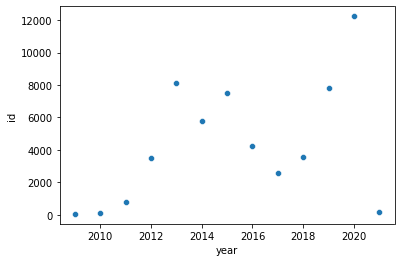

In [17]:
sns.scatterplot(data=tweets_per_year)

In [18]:
import re

In [19]:
common_targets = ['obama', 'hillary', 'clinton', 'barrack']

count = df.text.apply(lambda x: any(word in common_targets for word in x.lower().split())).sum()
print(f"Number of times Barack Obama or Hillary Clinton are mentioned in DJT Tweets\n{count} out of {len(df)}")

Number of times Barack Obama or Hillary Clinton are mentioned in DJT Tweets
2235 out of 56571


In [20]:
df[df.text.apply(lambda x: ("RT" in x[:3]))]['text'].count()

10010

### Data Exploration

In [21]:
df[df.text.apply(lambda x: "@" in x)]['text'].count()

32876

In [22]:
# Find targets of @'s

def at_target(text):
    text = text.split()
    targets = []
    for word in text:
        if word[0] == '@':
            targets.append(word.strip(":|.|\""))
    if len(targets) == 0:
        targets = ['None']
    return targets

In [23]:
tweet_targets = list(df.text.apply(lambda x: at_target(x)))

target_count = Counter()
for targets in tweet_targets:
    for target in targets:
        target_count[target]+=1

print(pd.Series(target_count.most_common(30)))
print(sum(target_count.values()))

0                 (None, 26526)
1     (@realDonaldTrump, 10195)
2               (@FoxNews, 811)
3            (@WhiteHouse, 788)
4         (@foxandfriends, 660)
5           (@BarackObama, 517)
6         (@ApprenticeNBC, 346)
7             (@TeamTrump, 315)
8                   (@CNN, 314)
9           (@IvankaTrump, 258)
10          (@seanhannity, 256)
11           (@MittRomney, 231)
12                  (@GOP, 226)
13        (@GOPChairwoman, 217)
14       (@DonaldJTrumpJr, 204)
15           (@DanScavino, 195)
16        (@BreitbartNews, 190)
17            (@EricTrump, 176)
18           (@Jim_Jordan, 169)
19              (@nytimes, 160)
20         (@GreggJarrett, 140)
21           (@megynkelly, 137)
22             (@dbongino, 137)
23               (@FLOTUS, 132)
24             (@LouDobbs, 130)
25        (@marklevinshow, 124)
26      (@LindseyGrahamSC, 123)
27                 (@OANN, 122)
28                (@POTUS, 119)
29        (@oreillyfactor, 118)
dtype: object
69378


In [24]:
pd.Series(map(len, tweet_targets)).value_counts(sort=False)

1     47261
2      6799
3      1842
4       466
5       144
6        34
7        11
8         6
9         4
11        4
dtype: int64

In [25]:
def find_hashtags(input_text):
    t = input_text.split()
    tag_list = []
    for word in t:
        if word[0] == "#":
            tag_list.append(word)
    return tag_list
        

### "Threads"
Tweets were limited to 140 characters and then changed to 280 characters. Because of their small character limit, users that wish to have longer messages must do so over multiple tweets - called threads.

In [26]:
df.text.apply(lambda x: x[-2:] == "..").sum()

4262

In [27]:
df.text.apply(lambda x: x[-1:] == ")").sum()

45

### Hyperlinks

In [28]:
count = df.text.apply(lambda x: "https:" in x).sum()

print(f"The number of tweets with hyperlinks is:\n{count} out of {len(df.text)} ({round(count/len(df.text)*100,1)}%)")

The number of tweets with hyperlinks is:
11511 out of 56571 (20.3%)


In [29]:
# Sample hyperlink
df[df.text.apply(lambda x: "https:" in x)]['text'].iloc[30]

'Biden lied Pennsylvania! https://t.co/zmD8Ew0bmS'

In [30]:
"""
First Method
# Make a method to strip out the hyperlinks
def hyperlink_remover(input_text):
    t = input_text
    start = 0
    end = 0
    while start >= 0:
        start = t.find("https")
        if start >= 0:
            if t[start:].find(" ") >=0:
                end = t[start:].find(" ") + start
            else:
                end = start+len(t[start:])
            t = t[:start]+t[end:]
    return t.strip()
    
"""

'\nFirst Method\n# Make a method to strip out the hyperlinks\ndef hyperlink_remover(input_text):\n    t = input_text\n    start = 0\n    end = 0\n    while start >= 0:\n        start = t.find("https")\n        if start >= 0:\n            if t[start:].find(" ") >=0:\n                end = t[start:].find(" ") + start\n            else:\n                end = start+len(t[start:])\n            t = t[:start]+t[end:]\n    return t.strip()\n    \n'

In [31]:
# Make a method to strip out the hyperlinks
def hyperlink_remover(input_text):
    t = input_text.split()
    output_string = ""
    for word in t:
        if "http" in word:
            start=word.find("https")
            s = " " + word[:start]
            output_string += s
            output_string = output_string.strip()
        else:
            output_string += (" " + word)
            output_string = output_string.strip()
    return output_string

In [32]:
# Testing the method
hyperlink_remover("https blah https pew pew pew asdasdhttps qerw")

'blah pew pew pew asdasd qerw'

In [33]:
# Test to make sure it gives the correct sum
foo = df.text.apply(lambda x: hyperlink_remover(x))

count = foo.apply(lambda x: "https:" in x).sum()

print(f"The number of tweets with hyperlinks is:\n{count} out of {len(df.text)} ({round(count/len(df.text)*100,1)}%)")

The number of tweets with hyperlinks is:
0 out of 56571 (0.0%)


In [34]:
df['text'] = df['text'].apply(lambda x: hyperlink_remover(x))

In [35]:
df['text']

0        Republicans and Democrats have both created ou...
1        I was thrilled to be back in the Great city of...
2        RT @CBS_Herridge: READ: Letter to surveillance...
3        The Unsolicited Mail In Ballot Scam is a major...
4        RT @MZHemingway: Very friendly telling of even...
                               ...                        
56566    RT @RandPaul: I don’t know why @JoeBiden think...
56567    RT @EliseStefanik: President @realDonaldTrump ...
56568    RT @TeamTrump: LIVE: Presidential Debate #Deba...
56569    Just signed an order to support the workers of...
56570    Suburban women want Safety &amp; Security. Joe...
Name: text, Length: 56571, dtype: object

## Models

In [36]:
generator = pipeline('text-generation', model='gpt2')
set_seed(42)

response = generator("Foreigners have taken a particular interest in otaku culture.", max_length=50, 
                     num_return_sequences=1, early_stopping=True, length_penalty=0.01)

for i, item in enumerate(response):
    print(i)
    print(item['generated_text'])

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


0
Foreigners have taken a particular interest in otaku culture. A large number of them have been writing in the language or using online platforms, such as the Internet or the video game community, for years. It isn't just a matter of the internet


In [37]:
PAD = "I DON’T do it for the money. I’ve got enough, much more than I’ll ever need. I do it to do it. Deals are my art form. Other people paint beautifully on canvas or write wonderful poetry. I like making deals, preferably big deals. That’s how I get my kicks. Most people are surprised by the way I work. I play it very loose. I don’t carry a briefcase. I try not to schedule too many meetings. I leave my door open. You can’t be imaginative or entrepreneurial if you’ve got too much structure. I prefer to come to work each day and just see what develops. There is no typical week in my life. I wake up most mornings very early, around six, and spend the first hour or so of each day reading the morning newspapers. I usually arrive at my office by nine, and I get on the phone. There’s rarely a day with fewer than fifty calls, and often it runs to over a hundred. In between, I have at least a dozen meetings. The majority occur on the spur of the moment, and few of them last longer than fifteen minutes. I rarely stop for lunch. I leave my office by six-thirty, but I frequently make calls from home until midnight, and all weekend long. It never stops, and I wouldn’t have it any other way. I try to learn from the past, but I plan for the future by focusing exclusively on the present. That’s where the fun is. And if it can’t be fun, what’s the point?"

In [38]:

#tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
#tokenizer.add_special_tokens({'pad_token': f'[{PAD}]'})

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.add_special_tokens({'pad_token': f'[{PAD}]'})

1

In [39]:
from torch.utils.data import Dataset, DataLoader
from transformers.data.processors.utils import InputFeatures

In [40]:
class TweetDataset(Dataset):
    def __init__(self, tweets, tokenizer, max_len):
        self.tweets,  self.tokenizer, self.max_len = tweets.to_numpy(), tokenizer, max_len
        
    def __len__(self):
        return len(self.tweets)
        
    def __getitem__(self, item):
        tweet = self.tweets[item]
        tokens = self.tokenizer.encode_plus(
            tweet,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return InputFeatures(input_ids = tokens['input_ids'].flatten().long().numpy().tolist(), 
                             attention_mask=tokens['attention_mask'].flatten().long().numpy().tolist())
    
def create_dataset(df, tokenizer, max_length, batch_size):
    return TweetDataset(df, tokenizer, max_length)

In [41]:
train_df, val_df = train_test_split(df['text'], test_size=0.1, random_state=42)

In [42]:
train_dataset = create_dataset(train_df, tokenizer, 780, 4)
eval_dataset = create_dataset(val_df, tokenizer, 780, 4)

In [43]:
model = GPT2Model.from_pretrained("gpt2")
for param in model.base_model.parameters():
    param.requires_grad = False
    
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total # of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset            # evaluation dataset
)

NameError: name 'GPT2Model' is not defined

In [44]:
%%time
#trainer.train()

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 8.82 µs


In [45]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = AutoModelWithLMHead.from_pretrained('gpt2')

/usr/local/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:966: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [53]:
train_df, val_df = train_test_split(df['text'], test_size=0.1, random_state=42)


In [55]:
train_df.shape

(50913,)

In [ ]:
train_df = list(train_df)
val_df = list(val_df)

In [47]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
train_mod_path = "train.txt"
test_mod_path = "test.txt"


train_m = ""
for tweet in train_df:
    train_m += (tokenizer.special_tokens_map['bos_token']+tweet.rstrip()+tokenizer.special_tokens_map['eos_token'])
          
with open(train_mod_path, "w", encoding='utf-8') as f:
    f.write(train_m)

test_m = ""
for tweet in val_df:
    test_m += (tokenizer.special_tokens_map['bos_token']+tweet.rstrip()+tokenizer.special_tokens_map['eos_token'])
        
with open(test_mod_path, "w", encoding='utf-8') as f:
    f.write(test_m)

In [48]:
from transformers import TextDataset, DataCollatorForLanguageModeling

In [56]:
def load_dataset(train_path,test_path,tokenizer):
    train_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=train_path,
          block_size=128)
    test_dataset = TextDataset(
          tokenizer=tokenizer,
          file_path=test_path,
          block_size=128)
    data_collator = DataCollatorForLanguageModeling(
        tokenizer=tokenizer, mlm=False,
    )
    return train_dataset,test_dataset,data_collator

In [57]:
train_dataset,test_dataset,data_collator = load_dataset(train_mod_path,test_mod_path,tokenizer)

In [58]:
training_args = TrainingArguments(
    output_dir="./storage/gpt2-motivational_v6", #The output directory
    overwrite_output_dir=True, #overwrite the content of the output directory
    num_train_epochs=2, # number of training epochs
    logging_steps = 500, # Number of update steps between two evaluations.
    save_steps=500, # after # steps model is saved
    warmup_steps=500,# number of warmup steps for learning rate scheduler
    )
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

In [59]:
trainer.train()
 
trainer.save_model("./storage/model")
 
tokenizer.save_pretrained("./storage/model")

Step,Training Loss


KeyboardInterrupt: 

In [9]:
tokenizer = AutoTokenizer.from_pretrained("./storage/model")
model = AutoModelWithLMHead.from_pretrained("./storage/model")

/usr/local/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:966: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


In [10]:
test = pipeline("text-generation", model=model, tokenizer=tokenizer)

In [15]:
response = test("", num_return_sequences=10)
for i, item in enumerate(response):
    print()
    print(item['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



The Fed is having problems with China but I think they should just give us free money as a country – and they can fix them as quickly as possible

"Why in the world did the “dummy” Mueller team get so damn fired up after having done so much research and investigating for a year, that they don't know any better?""Because they didn’t even look

RT @RepMarkMeadows: On the flipside, a new round of impeachment hearings is now underway with more allegations of…

A little over a year after the Election, let’s talk about the Election!

You may not get a response right away. You will be waiting…

My Administration has made it a priority to get our great Navy &amp; Coast Guard to stay safely &amp; safely in our Southern Border. There really is no doubt!

We’ve just watched the destruction and destruction by ISIS of the wonderful @BastilleRoyal in Nice, France-





.@OANN was on to talk with @realDonaldTrump about the great @VanityFair- http://t.co/HVdHl0dwVm


In [16]:
response = test("", num_return_sequences=10, top_p=0.92)
for i, item in enumerate(response):
    print()
    print(item['generated_text'])

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.









Tremendous job numbers in Alabama, including a record number of jobs. @FoxBusiness



"@greta @realDonaldTrump ""You're fired."" I love him, I like the fact that he speaks a lot of Chinese."""

We will be holding a major news conference at 10:00 A.M. Eastern (Eastern), shortly!

Criminals and their allies would be in the best position to make big gains by stealing our guns from us.” @BreitbartNews

Totally unrelated to the @FoxNews Polls.

It has taken almost two decades for the U.S. to negotiate trade deals that are meaningful and long overdue. We will now be getting a stronger deal. @TrumpGulfUSMCA


In [ ]:
# SPECIAL_TOKENS = ["<bos>", "<eos>", "<speaker1>", "<speaker2>", "<pad>"]
SPECIAL_TOKENS = ['<RT>', '<qstart>', '<qend>']

In [2]:
foo = {'shape': 'square', 'color': 'blue'}
print(type(foo['shape']))
print(type(foo.get('shape')))

<class 'str'>
<class 'str'>


In [3]:
import random
random.shuffle()

TypeError: shuffle() missing 1 required positional argument: 'x'